In [5]:
%load_ext autoreload
%autoreload 2

from data.dataloader import DataLoader

In [6]:
!pwd

/Users/wongpuihang/Desktop/NLP Assignment 2/NLP_A2_2025


In [7]:
import pandas as pd
data = pd.read_csv('data/dataset.csv')

In [18]:
from data.dataloader import text_clean
import spacy
import warnings
warnings.filterwarnings("ignore")

# preprocess title column
nlp = spacy.load("en_core_web_sm")

data['cleaned_title'] = data['title'].apply(
            lambda x: text_clean(x, nlp)
        )

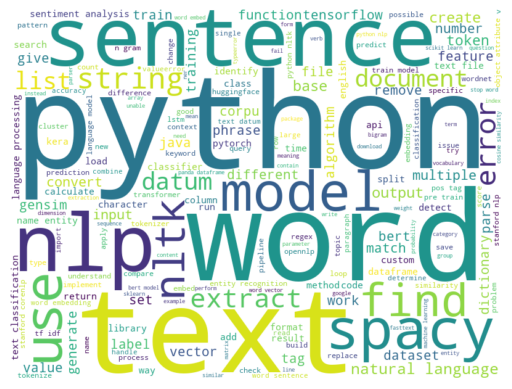

In [21]:
# generate wordcloud for the title in posts

from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(word for word in data['cleaned_title'])
wordc = WordCloud(width = 800, height = 600, background_color='white').generate(text)
plt.figure()
plt.imshow(wordc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize

vectorizer = TfidfVectorizer(max_df=0.85)
tfidf = vectorizer.fit_transform(data['cleaned_title'])

feature_names = vectorizer.get_feature_names_out()
idf_scores = vectorizer.idf_

# create a dictionary mapping each term to its IDF score.
idf_dict = dict(zip(feature_names, idf_scores))

# sort the terms based on the IDF scores (lowest first).
sorted_terms = sorted(idf_dict.items(), key=lambda item: item[1])
#print(sorted_terms)

# create custom stop words list to add those terms with low IDF score (threshold < 3.5)
custom_stop_words = []
for term, score in sorted_terms:
    if score <= 3.5:
        custom_stop_words.append(term)

# again perform stop word removal
def custom_stop_word_removal(text):
    tokens = word_tokenize(text)
    text = [word for word in tokens if word.lower() not in custom_stop_words]
    text = " ".join(text)
    return text

data['cleaned_title'] = data['cleaned_title'].apply(custom_stop_word_removal)

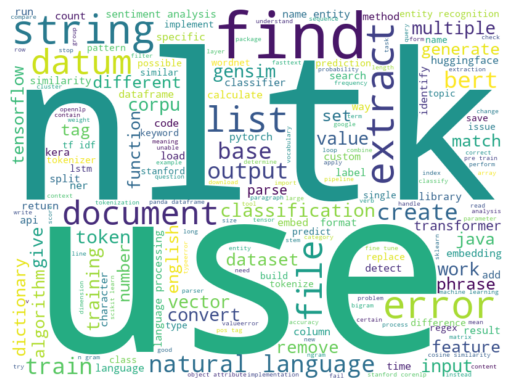

In [47]:
updated_text = " ".join(word for word in data['cleaned_title'])
updated_wordc = WordCloud(width = 800, height = 600, background_color='white').generate(updated_text)
plt.figure()
plt.imshow(updated_wordc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [26]:
# unsupervised topic modelling - LDA

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

LDA_vectorizer = CountVectorizer(max_df=0.85)
LDA_tfidf = LDA_vectorizer.fit_transform(data['cleaned_text'])

lda = LatentDirichletAllocation(n_components=15)
lda.fit(LDA_tfidf)

feature_names = LDA_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[-5:]]
    print(f"Topic {topic_idx}: {' '.join(top_words)}")

Topic 0: model ner name spacy entity
Topic 1: run code try file error
Topic 2: sentence similarity find document word
Topic 3: datum answer query user question
Topic 4: email text product search cluster
Topic 5: nltk language word pos tag
Topic 6: algorithm language function probability token
Topic 7: try like list text word
Topic 8: nlp tweet machine category text
Topic 9: string row dataframe list column
Topic 10: example noun parse like sentence
Topic 11: dataset datum training train model
Topic 12: nlp like language extract text
Topic 13: review positive negative analysis sentiment
Topic 14: layer input word embed vector


In [40]:
# !pip install bertopic
# !pip install tf-keras

In [52]:
# topic Labelling - BERTopic

from bertopic import BERTopic
import tf_keras as keras
import warnings
warnings.filterwarnings("ignore")

topic_model = BERTopic(nr_topics=10)
topics, probs = topic_model.fit_transform(data['cleaned_text'])

topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,9673,-1_word_text_model_sentence,"[word, text, model, sentence, like, try, use, ...",[use language model prediction fine tuning tra...
1,0,7444,0_word_text_like_sentence,"[word, text, like, sentence, want, try, code, ...",[generate find short text give list word let l...
2,1,1479,1_model_bert_word_vector,"[model, bert, word, vector, train, embed, embe...",[well custom training bert model use model pre...
3,2,1076,2_error_try_model_code,"[error, try, model, code, run, get, follow, im...",[pretraine model try use pretraine model creat...
4,3,138,3_memory_process_run_file,"[memory, process, run, file, spacy, gb, time, ...",[share complex spacy nlp model multiple python...
5,4,115,4_tweet_emoji_twitter_sentiment,"[tweet, emoji, twitter, sentiment, datum, word...",[accurate twitter sentiment analysis solution ...
6,5,36,5_countvectorizer_sklearn_scikit_word,"[countvectorizer, sklearn, scikit, word, count...",[sklearn countvectorizer custom vocabulary set...
7,6,15,6_number_convert_string_value,"[number, convert, string, value, write, word, ...",[convert number english string website like tr...
8,7,13,7_bleu_score_calculate_level,"[bleu, score, calculate, level, value, candida...",[bleu score value high look bleu score work un...
9,8,11,8_maltparser_parse_java_parser,"[maltparser, parse, java, parser, model, proba...",[parse raw text maltparser java find nlkt pyth...


In [61]:
# dig deeper into topic -1 (outliers group)

subset_topic_negative_1 = [doc for doc, topic in zip(data['cleaned_text'], topics) if topic == -1]

subset_negative_1_topic_model = BERTopic(nr_topics=10)
subset_topics_negative_1, subset_probs_negative_1 = subset_negative_1_topic_model.fit_transform(subset_topic_negative_1)

subset_negative_1_topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,5703,-1_word_model_text_sentence,"[word, model, text, sentence, try, like, use, ...",[use language model prediction fine tuning tra...
1,0,2389,0_word_sentence_text_like,"[word, sentence, text, like, want, find, use, ...",[list natural language processing tool regard ...
2,1,543,1_dataframe_column_row_word,"[dataframe, column, row, word, panda, text, li...",[efficient way add column panda dataframe conc...
3,2,358,2_model_layer_train_transformer,"[model, layer, train, transformer, input, kera...",[implement multi label text classifier keras t...
4,3,338,3_error_try_run_code,"[error, try, run, code, model, file, import, g...",[give output false code give follow error try ...
5,4,168,4_spacy_error_pipeline_try,"[spacy, error, pipeline, try, version, load, c...",[spacy error new spacy need help follow error ...
6,5,103,5_embedding_embed_word_vector,"[embedding, embed, word, vector, sentence, mod...",[calculate word embedding fasttext try calcula...
7,6,43,6_tokenizer_token_bert_wordpiece,"[tokenizer, token, bert, wordpiece, tokenizati...",[padding huggingface tokenizer work try follow...
8,7,15,7_deploy_flask_heroku_app,"[deploy, flask, heroku, app, error, azure, doc...",[face issue try deploy app flask gunicorn face...
9,8,13,8_numpy_array_loop_element,"[numpy, array, loop, element, list, dot, index...",[group numpy array element loop text processin...


In [62]:
# dig deeper into topic 0

subset_topic_0 = [doc for doc, topic in zip(data['cleaned_text'], topics) if topic == 0]

subset_0_topic_model = BERTopic(nr_topics=10)
subset_topics_0, subset_probs_0 = subset_0_topic_model.fit_transform(subset_topic_0)

subset_0_topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,433,-1_like_sentence_text_word,"[like, sentence, text, word, want, example, us...",[retrieve intent start use enhance small bot a...
1,0,4932,0_word_sentence_text_like,"[word, sentence, text, like, model, document, ...",[way load spacy train model gensim want list s...
2,1,1025,1_word_list_remove_string,"[word, list, remove, string, text, column, fil...",[remove stopword list list python natural lang...
3,2,312,2_pdf_extract_text_file,"[pdf, extract, text, file, page, table, scrape...",[unable extract text pdf file try extract text...
4,3,249,3_stanford_error_opennlp_corenlp,"[stanford, error, opennlp, corenlp, model, fil...",[stanford nlp runtimeioexception try sentiment...
5,4,242,4_intent_chatbot_bot_user,"[intent, chatbot, bot, user, luis, dialogflow,...",[intent issue have real difficulty understand ...
6,5,99,5_spark_pyspark_dataframe_column,"[spark, pyspark, dataframe, column, error, try...",[spark nlp method error bert zero shot classif...
7,6,71,6_google_api_cloud_error,"[google, api, cloud, error, language, openai, ...",[request insufficient authentication scope mak...
8,7,43,7_tokenizer_keras_huggingface_token,"[tokenizer, keras, huggingface, token, train, ...",[keras tokenizer handle unseen datum train tok...
9,8,38,8_plot_word_frequency_graph,"[plot, word, frequency, graph, axis, ggplot, y...",[plot word topic stm possible plot word topic ...


In [63]:
# dig deeper into topic 1

subset_topic_1 = [doc for doc, topic in zip(data['cleaned_text'], topics) if topic == 1]

subset_1_topic_model = BERTopic(nr_topics=10)
subset_topics_1, subset_probs_1 = subset_1_topic_model.fit_transform(subset_topic_1)

subset_1_topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,110,-1_vector_model_output_layer,"[vector, model, output, layer, word, hot, inpu...",[convert hot encoding dence vector nlp experim...
1,0,501,0_word_vector_embed_model,"[word, vector, embed, model, embedding, probab...",[gensim fasttext pre trained model vector voca...
2,1,469,1_bert_model_error_fine,"[bert, model, error, fine, try, use, sentence,...",[miss require positional argument want use ber...
3,2,176,2_lstm_model_input_text,"[lstm, model, input, text, output, sequence, t...",[keras lstm handle sequence tagging sentence b...
4,3,74,3_model_save_train_training,"[model, save, train, training, epoch, hug, fac...",[hug face model pre trained train want use hug...
5,4,54,4_glove_word_vector_embedding,"[glove, word, vector, embedding, file, embed, ...",[use glove word embed non english text try run...
6,5,28,5_attention_head_layer_self,"[attention, head, layer, self, shape, matrix, ...",[attention calculation matrix level confuse ca...
7,6,25,6_loss_accuracy_training_epoch,"[loss, accuracy, training, epoch, result, chan...",[loss function negative log likelihood give lo...
8,7,24,7_crf_mallet_stanford_ner,"[crf, mallet, stanford, ner, feature, model, d...",[pass array float train stanford crfclassifier...
9,8,18,8_perplexity_calculate_language_model,"[perplexity, calculate, language, model, metri...",[calculate perplexity model train gensim model...
